<a href="https://colab.research.google.com/github/dragonmachinelearning/ML/blob/main/Coderschool_DeepLearning_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs Dogs

Create an algorithm to distinguish cats from dogs!

In this section, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

#Important note: 

Before starting, make sure to make a copy of this file in your drive by going to File => Save a copy in Drive!

# Import library

We will import all the necessary libraries and tensorflow functions/modules to build and train our deep learning model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.cm as cm
import os                  
import shutil              
from pathlib import Path
import random
import cv2

# import all the necessary tensorflow functions/modules for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.imagenet_utils import decode_predictions


In [ ]:
# Checking python and tensorflow version
!python --version
print(tf.__version__)

Python 3.7.10
2.4.1


In [ ]:
!nvidia-smi

Sat Mar 20 09:22:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We will also set the desired image height and width. All of our images will be cropped to this size before training

In [ ]:
HEIGHT = 224
WIDTH = 224

# Download your cats and dogs images

We will download our dogs-vs-cats dataset from this URL

In [ ]:
!wget 'https://s3.amazonaws.com/fast-ai-sample/dogscats.tgz'

--2021-03-20 09:22:16--  https://s3.amazonaws.com/fast-ai-sample/dogscats.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.97.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.97.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839285364 (800M) [application/x-tar]
Saving to: ‘dogscats.tgz’

dogscats.tgz        100%[===================>] 800.40M  46.4MB/s    in 18s     

2021-03-20 09:22:34 (45.5 MB/s) - ‘dogscats.tgz’ saved [839285364/839285364]



We will then extract our .tgz files (archive files) using this command

In [ ]:
!tar -xzf dogscats.tgz

# Data Exploration

Let's take a look our lovely dogs and cats! But first, we need to get a list of image paths for each dog and cat

In [ ]:
DATA_PATH = Path('./dogscats')
dog_paths = [str(i) for i in (DATA_PATH/'train/dogs').glob('*') if i.is_file()]
cat_paths = [str(i) for i in (DATA_PATH/'train/cats').glob('*') if i.is_file()]

Here are the first 5 image paths for dogs

In [ ]:
dog_paths[:5]

['dogscats/train/dogs/dog.497.jpg',
 'dogscats/train/dogs/dog.602.jpg',
 'dogscats/train/dogs/dog.10008.jpg',
 'dogscats/train/dogs/dog.9350.jpg',
 'dogscats/train/dogs/dog.5544.jpg']

... and first 5 image paths for cats

In [ ]:
cat_paths[:5]

['dogscats/train/cats/cat.7016.jpg',
 'dogscats/train/cats/cat.7066.jpg',
 'dogscats/train/cats/cat.5644.jpg',
 'dogscats/train/cats/cat.3913.jpg',
 'dogscats/train/cats/cat.1283.jpg']

Note that these images are not stored in your computer. They are stored in a temporary folder in Google Colab, which will be deleted after a period of idle time

We can also check how many cat images and dog images available to train

In [ ]:
print(f"Number of dog images in our train dataset: {len(dog_paths)}")
print(f"Number of cat images int our train dataset: {len(cat_paths)}")

Number of dog images in our train dataset: 11500
Number of cat images int our train dataset: 11500


We are ready to show these images! Run the cell below to load a function called ```show_gallery```

In [ ]:
#@title
def reset_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
reset_seed()

def get_side(img, side_type, n = 5):
    h, w, c = img.shape
    if side_type == "horizontal":
        return np.ones((h,n,c))
    return np.ones((n,w,c))

def show_gallery(im_ls,n=5, shuffle=True):
    '''
    Adapted with serveral modifications 
    from https://www.kaggle.com/serkanpeldek/keras-cnn-transfer-learnings-on-cats-dogs-dataset
    '''
    images = []
    vertical_images = []
    if shuffle:
        random.shuffle(im_ls)
    vertical_images = []
    for i in range(n*n):
        img = load_img(im_ls[i], target_size=(HEIGHT,WIDTH))
        img = img_to_array(img)
        hside = get_side(img,side_type="horizontal")
        images.append(img)
        images.append(hside)
        
        if (i+1) % n == 0:
            himage=np.hstack((images))
            vside = get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images = []
        
    gallery = np.vstack((vertical_images))
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(gallery.astype(np.uint8))
    plt.show()

Now we are able to use ```show_gallery``` function to display the images, given the image paths. Run these 2 cells below several times to see different images of dogs and cats in our train dataset

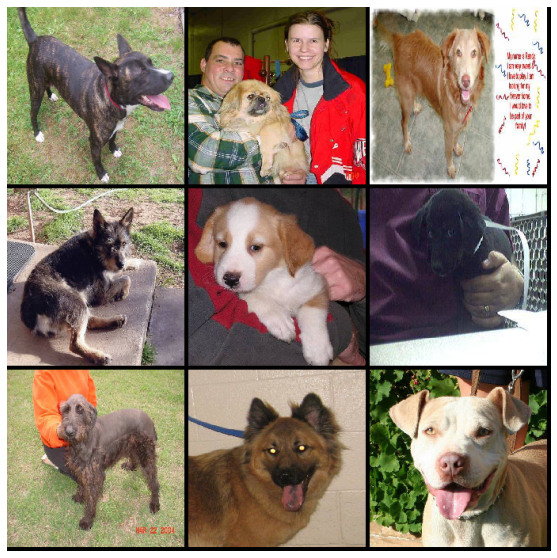

In [ ]:
# Show dog images
show_gallery(dog_paths, n=3)

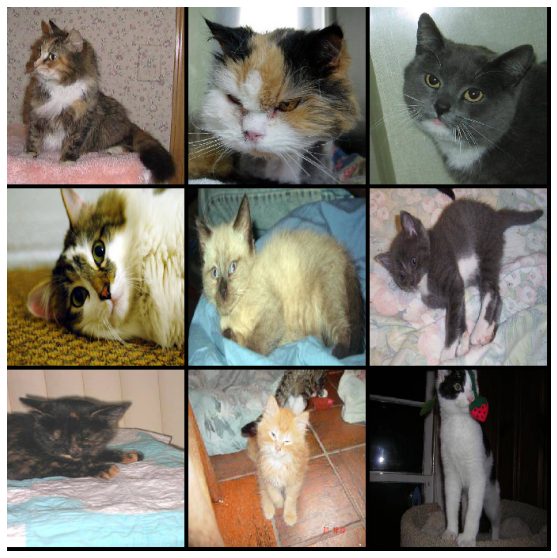

In [ ]:
# Show cats images
show_gallery(cat_paths, n=3)

# Awesome! Now it's time to build and train your first deep learning model

## Prepare data for your model using Tensorflow 2

Believe it or not, we will be able to train your model using a free GPU provided by Google (yay!). However, before training your model, it's important to get your data ready with some preprocessing

Typically with deep learning, we are not going to load every image into the GPU (since we are working with images, your dataset will get really large in size). Instead, we will use something called **generator** which will only load images when they are needed. This function below will help you prepare such **generator**. With **batch_size = 32**, this means we will generate a batch of 32 images at a time.

Another best practice that we should follow when training a deep learning model is to use another dataset called **validation set**, which we only use to check our model's performance. **We won't train the model on this set!**. Doing well on this **validation set** meaning your model can work well with future, unseen data

In [ ]:
def prepare_data(batch_size):
    train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

    train_generator = train_datagen.flow_from_directory(
                            DATA_PATH/'train', 
                            target_size=(HEIGHT,WIDTH),
                            batch_size=batch_size,
                            shuffle=True,
                            seed=42,
                            class_mode='categorical')
    
    validation_generator = val_datagen.flow_from_directory(
                            DATA_PATH/'valid',
                            target_size=(HEIGHT,WIDTH),
                            batch_size=batch_size,
                            shuffle=False,
                            class_mode='categorical')
    
    return train_generator,validation_generator


BATCH_SIZE = 32
train_generator,val_generator = prepare_data(BATCH_SIZE)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Choosing a deep learning architecture

In this step, we will use a model that has already been created, trained and won the 2015 ImageNet Large Scale Visual Recognition Challenge (in both image classification and object detection). This model is called ResNet, short for Residual Networks, and it is developed by Microsoft researchers. Even though it is created in 2015, it has been considered a 'classic' deep learning architecture as it has been used as backbone for many computer vision tasks. The fundamental breakthrough with this model is that **it allowed use to train extremely deep neural networks with more than 100 layers**


Here is a rough visualization of this architecture.
![](https://images.viblo.asia/full/fe5b21e5-3ad3-4419-93e0-7aa77a662bdd.png)

Don't worry too much about the details. If you want to learn more about ResNet, this [series on Medium](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) will go into more details on how ResNet is implemented and why it is so effective. 

In [ ]:
resnet = ResNet50V2(include_top=False, pooling="avg", weights='imagenet')
for layer in resnet.layers:
    layer.trainable=False

logits = Dense(2)(resnet.output)
output = Activation('softmax')(logits)
model = Model(resnet.input, output)

94674944/94668760 [==============================] - 1s 0us/step


Run this code to truly get the meaning of a **deep** learning model!

In [ ]:
model.summary()

Each deep learning model needs an **optimizer**. We will use an optimizer called **Stochastic Gradient Descent**, which is an optimization algorithm to minimize our **loss function**, thus help improve our model's performance

In [ ]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

As mentioned, we need to minimize a **loss function**, but what is that? The entire purpose of **loss function** is to define a measure of performance that our model can use to update automatically. For this problem, we will use a loss function called *categorical cross entropy*. You don't need to fully understand what this is, because this is just a kind of function that is mathematically easy for the model to update itself using Stochastic Gradient Descent

Instead, we will rely on **metric**, which is defined for human consumption. A good metric is one that is easy for you to understand. In this problem, we will use a metric called **accuracy**. Accuracy is the fraction of predictions our model got right. For example, if your model can correctly predict 80 images out of 100 images, then the accuracy of your model is 0.8, or 80%

In [ ]:
model.compile(optimizer=sgd, loss = "categorical_crossentropy", metrics=["accuracy"])

We will need a checkpoint to save our best version of the model to a physical file with extension h5

In [ ]:
checkpointer = ModelCheckpoint(filepath="./resnet50best.h5", monitor='val_loss', save_best_only=True, mode='auto')

For the time being, we will only train this model for 2 **epochs**, which means we will let the model train on our entire dataset for 2 times

In [ ]:
history = model.fit(
    train_generator, 
    epochs=3,
    validation_data=val_generator,
    callbacks=[checkpointer]
)

Epoch 1/2
719/719 [==============================] - 121s 123ms/step - loss: 0.0881 - accuracy: 0.9748 - val_loss: 0.0783 - val_accuracy: 0.9805
Epoch 2/2
719/719 [==============================] - 86s 120ms/step - loss: 0.0461 - accuracy: 0.9878 - val_loss: 0.0700 - val_accuracy: 0.9855


Congrats! You have succesfully trained your first deep learning model on an image classfication task. Look how high your accuracy score is!

# Visualize your model prediction with GradCAM

As you can see, your deep learning model can reach such unprecedented accuracy in this task, but one of the biggest problem is **model interpretability**, a core component in model understanding and model debugging. You won't be able to debug 100+ layers in the same way to debug a typical software application!

Therefore, deep learning models are treated as “black box” methods, and many times **we have no reasonable idea as to where the network is "looking"** in the input image to make a prediction, which raises a valid concern: **how can you trust the decisions of a model if you can't even validate how it got there?**


Fortunately, there is a technique called Grad-CAM (Gradient-weighted Class Activation Mapping) which produces visual explanations from a large class of CNN-based models, making them more transparent. As mentioned in [Grad-CAM research paper](https://arxiv.org/abs/1610.02391):

- *Grad-CAM uses the gradients of any target concept, flowing into the **final convolutional layer** to **produce a coarse localization map highlighting the important regions in the image for predicting the concept**.”*


We will use this technique to confirm the high accuracy of your model. The code for GradCAM is adapted from this [blog post](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/) with some modification to suit our task.

In [ ]:
#@title Run this cell to load GradCAM

class GradCAM:
    ''' 
    Adapted with some modification 
    from https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
    '''
    def __init__(self, model, layerName=None):
        """
        model: pre-softmax layer (logit layer)
        """
        self.model = model
        self.layerName = layerName
            
        if self.layerName == None:
            self.layerName = self.find_target_layer()
    
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")
            
    def compute_heatmap(self, image, classIdx, upsample_size, eps=1e-5):
        gradModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output, self.model.output]
        )
        # record operations for automatic differentiation
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOuts, preds) = gradModel(inputs) # preds after softmax
            loss = preds[:,classIdx]
        
        # compute gradients with automatic differentiation
        grads = tape.gradient(loss, convOuts)
        # discard batch
        convOuts = convOuts[0]
        grads = grads[0]
        norm_grads = tf.divide(grads, tf.reduce_mean(tf.square(grads)) + tf.constant(eps))
        
        # compute weights
        weights = tf.reduce_mean(norm_grads, axis=(0,1))
        cam = tf.reduce_sum(tf.multiply(weights, convOuts), axis=-1)
        
        # Apply reLU
        cam = np.maximum(cam, 0)
        cam = cam/np.max(cam)
        cam = cv2.resize(cam, upsample_size,interpolation=cv2.INTER_LINEAR)
        
        # convert to 3D
        cam3 = np.expand_dims(cam, axis=2)
        cam3 = np.tile(cam3, [1,1,3])
        
        return cam3
    
def overlay_gradCAM(img, cam3):
    cam3 = np.uint8(255*cam3)
    cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
    
    new_img = 0.3*cam3 + 0.5*img
    
    return (new_img*255.0/new_img.max()).astype("uint8")


@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

class GuidedBackprop:
    def __init__(self,model, layerName=None):
        self.model = model
        self.layerName = layerName
        self.gbModel = self.build_guided_model()
        
        if self.layerName == None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply Guided Backpropagation")

    def build_guided_model(self):
        gbModel = Model(
            inputs = [self.model.inputs],
            outputs = [self.model.get_layer(self.layerName).output]
        )
        layer_dict = [layer for layer in gbModel.layers[1:] if hasattr(layer,"activation")]
        for layer in layer_dict:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guidedRelu
        
        return gbModel
    
    def guided_backprop(self, images, upsample_size):
        """Guided Backpropagation method for visualizing input saliency."""
        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            outputs = self.gbModel(inputs)

        grads = tape.gradient(outputs, inputs)[0]

        saliency = cv2.resize(np.asarray(grads), upsample_size)

        return saliency

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
#@title Run this cell to prepare for GradCAM visualization

def show_gradCAMs(model, gradCAM, GuidedBP, im_ls, n=3, decode={}):
    """
    model: softmax layer
    """
    random.shuffle(im_ls)
    plt.subplots(figsize=(15, 5*n))
    k=1
    for i in range(n):
        img = cv2.imread(im_ls[i])
        upsample_size = (img.shape[1],img.shape[0])
        # Show original image
        plt.subplot(n,3,k)
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        plt.title("Filename: {}".format(im_ls[i]), fontsize=10)
        plt.axis("off")
        # Show overlayed grad
        plt.subplot(n,3,k+1)
        im = img_to_array(load_img(im_ls[i], target_size=(HEIGHT,WIDTH)))
        x = np.expand_dims(im, axis=0)
        x = preprocess_input(x)
        preds = model.predict(x)
        idx = preds.argmax()
        if len(decode)==0:
            res = decode_predictions(preds)[0][0][1:]
        else:
            res = [decode[idx],preds.max()]
        cam3 = gradCAM.compute_heatmap(image=x, classIdx=idx, upsample_size=upsample_size)
        new_img = overlay_gradCAM(img, cam3)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        plt.imshow(new_img)
        plt.title("GradCAM - Pred: {}. Prob: {}%".format(res[0],round(res[1]*100,2)), fontsize=10)
        plt.axis("off")
        
        # Show guided GradCAM
        plt.subplot(n,3,k+2)
        gb = GuidedBP.guided_backprop(x, upsample_size)
        guided_gradcam = deprocess_image(gb*cam3)
        guided_gradcam = cv2.cvtColor(guided_gradcam, cv2.COLOR_BGR2RGB)
        plt.imshow(guided_gradcam)
        plt.title("Guided GradCAM", fontsize=10)
        plt.axis("off")
        
        k += 3
    plt.show()

Let's load the best version of your model

In [ ]:
model.load_weights("./resnet50best.h5")

... and make some preparations for our Grad-CAM visualization

In [ ]:
model_logit = Model(model.input,model.layers[-2].output)
gradCAM = GradCAM(model=model_logit, layerName="conv5_block3_out")
guidedBP = GuidedBackprop(model=model,layerName="conv5_block3_out")

We will apply Grad-CAM on our validation set. In order to prepare for that, we need to get the predictions of your model on the validation set. We will also get the true labels (ground truth) and a list of file names of the images

In [ ]:
# get model predictions and their indices
predictions = model.predict(val_generator, verbose = 1)
pred_indices = np.argmax(predictions,axis=1)

# get labels and image paths of validation set
ground_truth = val_generator.classes
filenames = np.array(val_generator.filenames)

63/63 [==============================] - 7s 108ms/step


## Which part of the images the model use to predict dogs?

We will get all the images of dogs where the model predictions match with the true labels

In [ ]:
dogs_correct_path = filenames[(pred_indices == ground_truth) & (ground_truth==1)]
dogs_correct_path = list(map(lambda x: str(DATA_PATH/'valid'/x),dogs_correct_path))

Finally! Let's see how a model can tell if it's a dog!

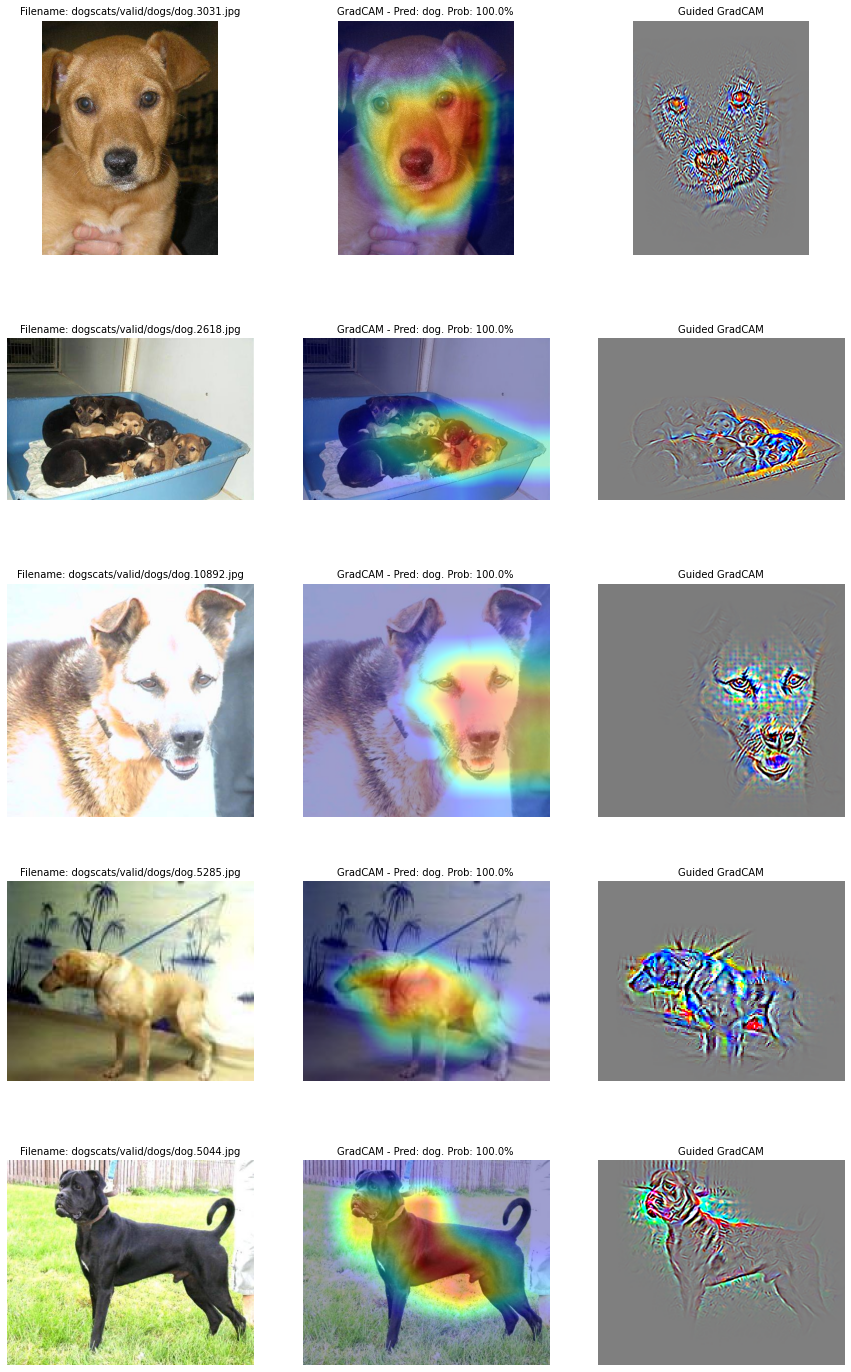

In [ ]:
show_gradCAMs(model, gradCAM,guidedBP,dogs_correct_path, n=5, decode={0:"cat", 1:"dog"})

## Which part of the images the model use to predict cats?

We will get all the images of cats where the model predictions match with the true labels

In [ ]:
cats_correct_path = filenames[(pred_indices == ground_truth) & (ground_truth==0)]
cats_correct_path = list(map(lambda x: str(DATA_PATH/'valid'/x),cats_correct_path))

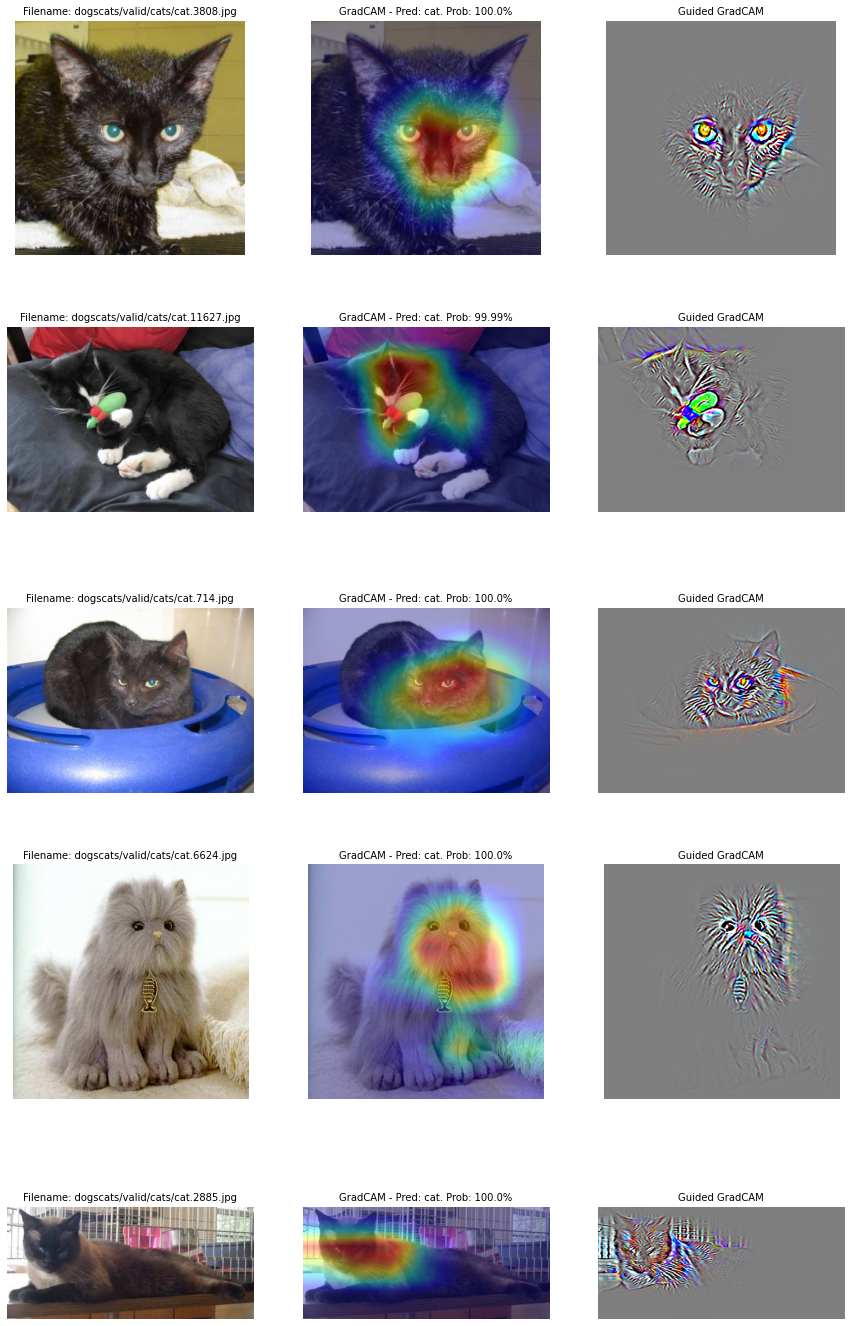

In [ ]:
show_gradCAMs(model, gradCAM,guidedBP,cats_correct_path, n=5, decode={0:"cat", 1:"dog"})

# Let's debug model's wrong predictions using Grad-CAM!

## These images are labeled as dogs, but your model predicts them as cats



In [ ]:
cat_but_actually_dog_path = filenames[(pred_indices != ground_truth) & (ground_truth==1)]
cat_but_actually_dog_path = list(map(lambda x: str(DATA_PATH/'valid'/x),cat_but_actually_dog_path))

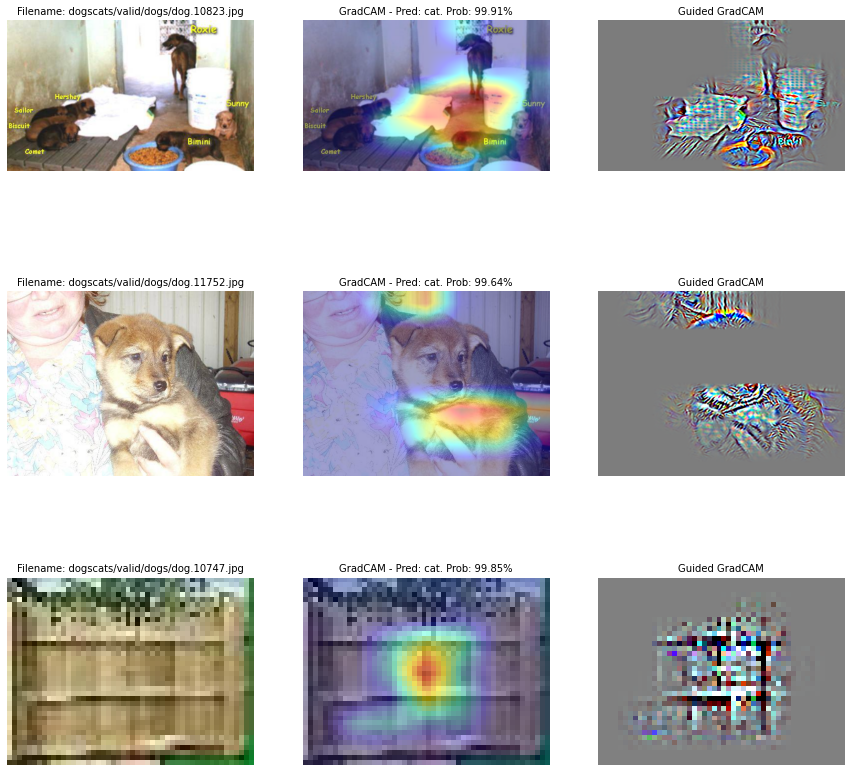

In [ ]:
show_gradCAMs(model, gradCAM,guidedBP,cat_but_actually_dog_path, n=3, decode={0:"cat", 1:"dog"})

## These images are labeled as cats, but your model predicts them as dogs

In [ ]:
dog_but_actually_cat_path = filenames[(pred_indices != ground_truth) & (ground_truth==0)]
dog_but_actually_cat_path = list(map(lambda x: str(DATA_PATH/'valid'/x),dog_but_actually_cat_path))

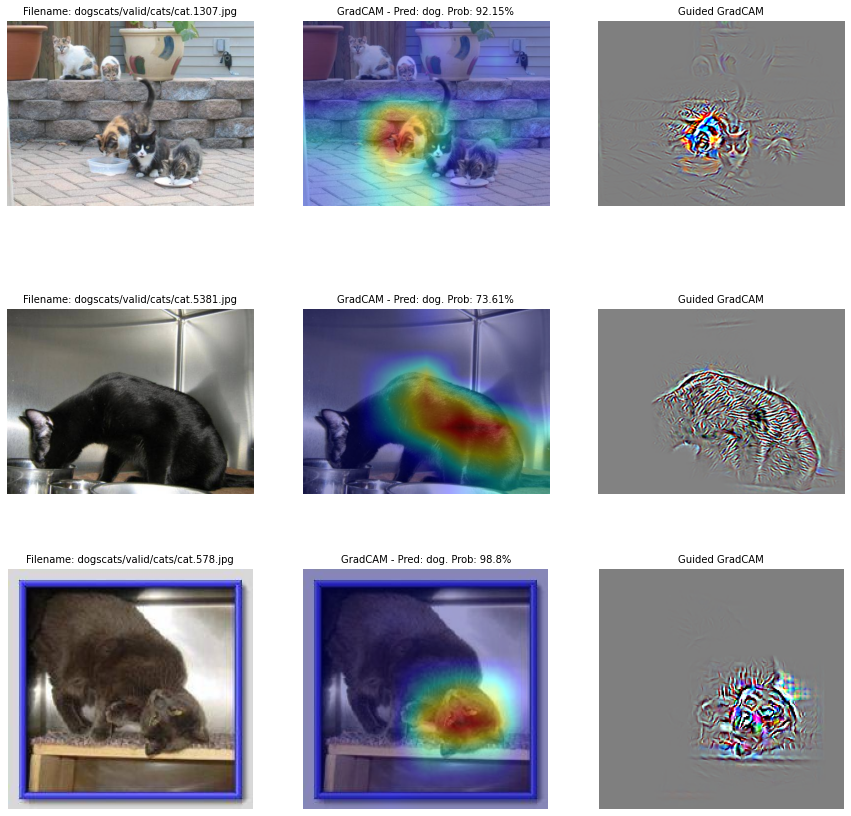

In [ ]:
show_gradCAMs(model, gradCAM,guidedBP,dog_but_actually_cat_path, n=3, decode={0:"cat", 1:"dog"})

# Upload your own image!

Now it's your time! You can add your own pet images and check if your model can make a correct prediction!

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  uploaded_path = '/content/' + fn
  print(f'You have uploaded this image file: {uploaded_path}' )

Saving Capture2.PNG to Capture2.PNG
You have uploaded this image file: /content/Capture2.PNG


Click on the 'Choose Files' button to upload your image!

Now, let's test if your image is a dog or a cat.

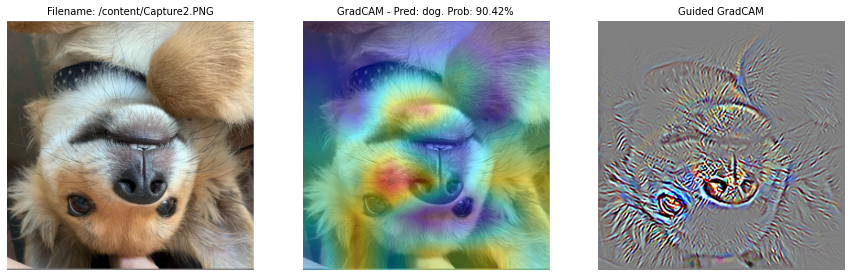

In [ ]:
show_gradCAMs(model, gradCAM,guidedBP,[uploaded_path], n=1, decode={0:"cat", 1:"dog"})